# FitzHugh-Nagumo Model

The FitzHugh-Nagumo (FHN) model was first introduced in the $1960s$ to describe the spiking of neurons. However, it may also be applied to other biological phenomena, including early embryonic cell cycle oscillations, and cardiac dynamics. This model captures the oscillatory behaviour in a **two-dimensional** framework. The model is moderately complex, utilizing a **cubic nonlinearity** to represent the interaction between its variables. The following form of the FHN model has been used:

$$
\frac{dx}{dt} = -x^3 + \gamma x^2 + \delta x - y,
$$

$$
\frac{dy}{dt} = \varepsilon (x - \beta y + \alpha).
$$

Here, the variables $x$ and $y$ represent the state variables specific to the system being modeled. For example, they may represent membrane potential and ion channel reactivation for neurons, or excitation and recovery of cardiac cells for cardiac dynamics. The coefficients $\alpha, \beta, \gamma, \delta, \epsilon$ represent the model parameters.

### Parameters

- $\alpha = 0$
- $\beta = 0.5$
- $\gamma = 1$
- $\delta = 1$
- $\varepsilon = 0.3$


In [1]:
import sys
print(sys.version)
print("--"* 60)
print(sys.executable)
print("--"* 60)

3.9.21 (main, Dec 11 2024, 16:24:11) 
[GCC 11.2.0]
------------------------------------------------------------------------------------------------------------------------
/home/alka23224/miniconda3/envs/tiseanpy/bin/python
------------------------------------------------------------------------------------------------------------------------


In [2]:
# -------------------------------
# Current working directory
# -------------------------------
import os
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")


Current working directory: /home/alka23224/4_Chapter_4_PyTISEAN


In [3]:
# # -------------------------------
# # Create a Folder for Plots
# # -------------------------------
plot_dir = os.path.join(current_dir, "Plots_1")
os.makedirs(plot_dir, exist_ok=True) 

In [4]:
# Import necessary libraries
import numpy as np   
import matplotlib.pyplot as plt 
from scipy.integrate import odeint 
from scipy.integrate import solve_ivp 

In [5]:
import tempfile
import pytisean.pytisean
# point pytisean’s temp‐dir to whatever tempfile.gettempdir() returns
pytisean.pytisean.DIRSTR = tempfile.gettempdir()
from pytisean import tiseano, tiseanio

In [6]:
import warnings
# Ignore all UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)
# Import helper
from plot_utils import set_plot_style, set_spines_black

In [7]:
# -------------------------------
#  Generate the Training Data
# --------------------------------
alpha=0
beta=0.5
gamma=1
delta=1
epsilon=0.3

def fitzhugh_nagumo_model(t,state,alpha,beta,gamma,delta,epsilon):
    x, y = state   
    dx_dt = -x**3 + gamma*x**2 + delta*x - y 
    dy_dt = epsilon * (x - beta*y + alpha)        
    return [dx_dt, dy_dt]


# Parameters for ODE Integrator
## Total simulation duration = 0 - 100 seconds
t_max = 100  # Maximum time for the simulation
dt = 0.001  # The time step
t_train = np.arange(0, t_max, dt) # Time points for simulation
X0 = [0.1, 0.0]  # Initial state of the system

# Solve with solve_ivp
x_train = solve_ivp(
    fitzhugh_nagumo_model,
    t_span=[0, t_max],
    y0=X0,
    args=(alpha,beta,gamma,delta,epsilon),
    t_eval=t_train,  
    method='LSODA'    
)

X =x_train.y.T  

In [8]:
# Print sizes of t_train, X 
print("Size of t_train:", t_train.shape)
print("Size of X:", X.shape)

Size of t_train: (100000,)
Size of X: (100000, 2)


In [9]:
x_t = X[:,0] # Choose x(t), a scaler time series

In [10]:
N = len(x_t)  # Get the length of the time series
print("The length of the time series x(t) is:", N)

The length of the time series x(t) is: 100000


## Time Delay

In [11]:
autocor_information, msg = tiseanio('autocor','-V',0, data=x_t)
autocor_information.shape

['autocor', '/tmp/pytisean_temp_2025-07-07-14-39-37_g7lftw7p.dat', '-V', '0', '-o', '/tmp/pytisean_temp_2025-07-07-14-39-37_3rfbevvw.dat']



(100000, 2)

In [12]:
time_delays = autocor_information[:, 0]  # The lag values (time delays)
autocorrelation_values = autocor_information[:, 1]  # The autocorrelation values
# Find time delay based on first crossing a threshold, e.g., 1/e
threshold = np.exp(-1)  # 1/e ≈ 0.37 
# Find the first index where autocorrelation falls below or equal to the threshold
time_delay_idx = np.where(autocorrelation_values <= threshold)[0][0]  # First crossing of 1/e
time_delay_value = time_delays[time_delay_idx]


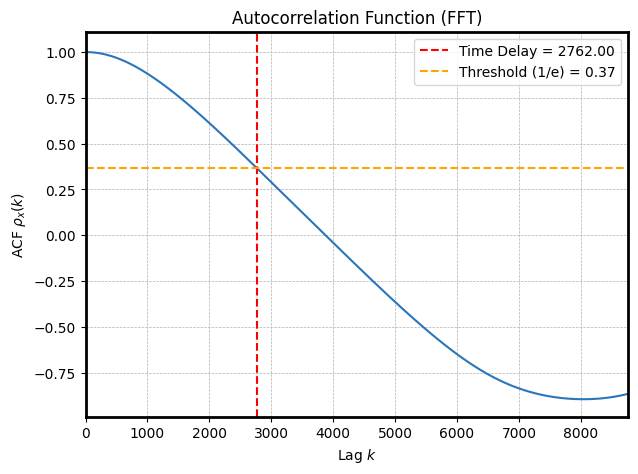

Selected  delay: 2762.0


In [13]:
# Plot the autocorrelation and mark the selected time delay
bluish = '#2976bb'
fig, ax = plt.subplots(figsize=(7, 5), dpi=100)
ax.set_title('Autocorrelation Function (FFT)')
ax.plot(time_delays, autocorrelation_values, color=bluish)
ax.set_xlabel(r'Lag $k$')
ax.set_ylabel(r'ACF $\rho_x(k)$')
plt.grid(True, which='both', ls='--', lw=0.5)

# Mark the time delay
ax.axvline(x=time_delay_value, color='r', linestyle='--', label=f'Time Delay = {time_delay_value:.2f}')
# Mark the threshold
ax.axhline(y=threshold, color='orange', linestyle='--', label=f'Threshold (1/e) = {threshold:.2f}')
set_spines_black(ax)
ax.legend()
ax.set_xlim(0, time_delay_idx + 6000) 

plt.savefig("Plots_1/TimeDelay_FitzHugh_Nagumo_model.pdf", bbox_inches="tight")
plt.show()

print(f"Selected  delay: {time_delay_value}")


## Embedding Dimesion

['false_nearest', '/tmp/pytisean_temp_2025-07-07-14-39-45_6cb6j06q.dat', '-m', '1', '-M', '1,5', '-d', '2762', '-f', '3', '-V', '0', '-o', '/tmp/pytisean_temp_2025-07-07-14-39-45_0_q7b7lc.dat']



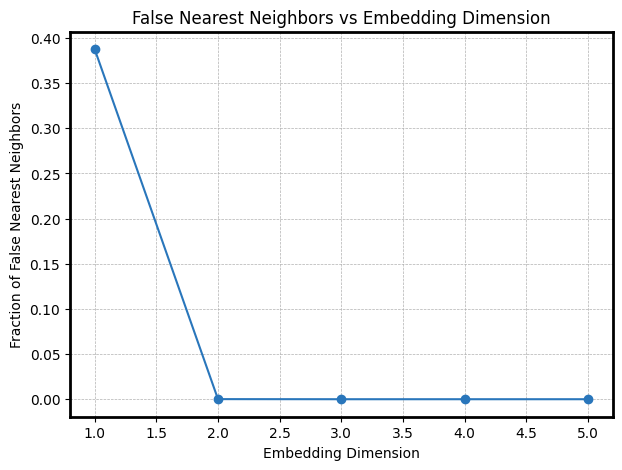

In [14]:
fnn_information, msg = tiseanio('false_nearest', '-m', 1, '-M', '1,5', '-d', 2762, '-f',3, '-V',0, data=x_t)
# Plot the fraction of false nearest neighbors against embedding dimension
embedding_dimensions = fnn_information[:, 0]  # First column: embedding dimensions
fnn_values = fnn_information[:, 1]            # Second column: fraction of false nearest neighbors

bluish = '#2976bb'
fig, ax = plt.subplots(figsize=(7, 5), dpi=100)
ax.set_title('False Nearest Neighbors vs Embedding Dimension')
ax.plot(embedding_dimensions, fnn_values, color=bluish, marker='o')
ax.set_xlabel('Embedding Dimension')
ax.set_ylabel('Fraction of False Nearest Neighbors')
set_spines_black(ax)
plt.grid(True, which='both', ls='--', lw=0.5)
plt.savefig("Plots_1/Embedding_Dimension_FitzHugh_Nagumo_model.pdf", bbox_inches="tight")
plt.show()


In [15]:
fnn_values

array([3.876436e-01, 1.044205e-04, 0.000000e+00, 0.000000e+00,
       0.000000e+00])

In [16]:
## Time Delay = 2762
## Embedding Dimension = 2

In [17]:
# To generate delay vectors
delay_information, msg = tiseanio('delay', '-m', 2, '-d', 2762, '-V', 0, data=x_t)

['delay', '/tmp/pytisean_temp_2025-07-07-14-39-53_1ou3sgyi.dat', '-m', '2', '-d', '2762', '-V', '0', '-o', '/tmp/pytisean_temp_2025-07-07-14-39-53_dssb8h9t.dat']



In [18]:
delay_information

array([[1.289573 , 0.1      ],
       [1.289993 , 0.1001091],
       [1.290412 , 0.1002183],
       ...,
       [1.328948 , 1.066608 ],
       [1.3288   , 1.067714 ],
       [1.328652 , 1.06882  ]])

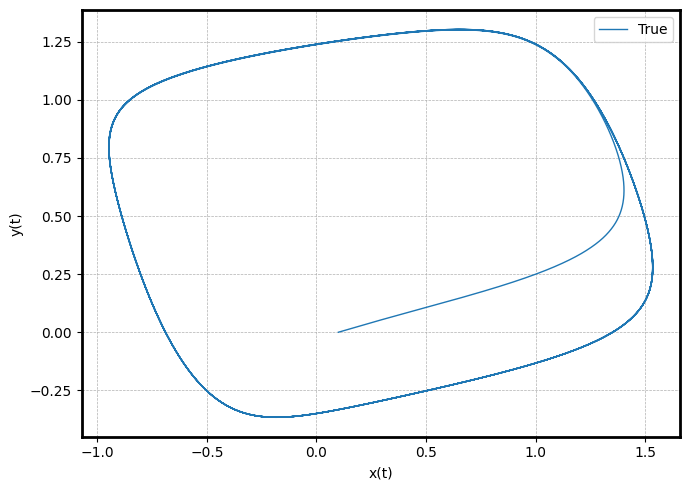

<Figure size 640x480 with 0 Axes>

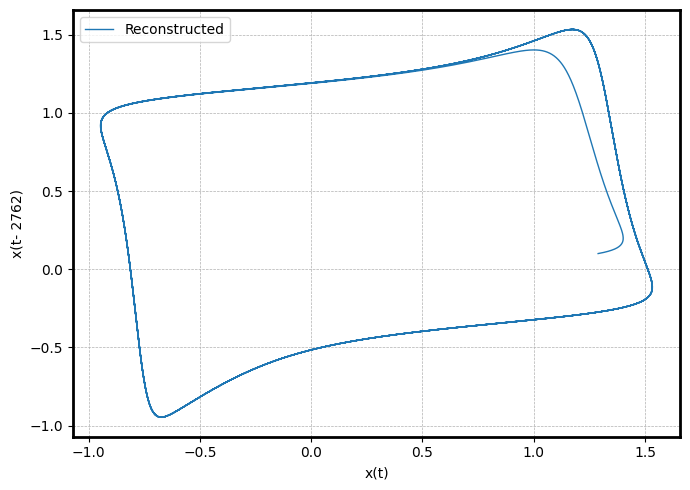

In [19]:
# Phase Digram
# True phase space 
fig1, ax1 = plt.subplots(figsize=(7, 5), dpi=100)
ax1.plot(X[:, 0], X[:, 1],lw=1.0, label='True')
ax1.set(xlabel='x(t)', ylabel='y(t)')
ax1.grid(True, which='both', ls='--', lw=0.5)
ax1.legend(loc='best')
set_spines_black(ax1)     
fig1.tight_layout()
plt.show()
plt.savefig("Plots_1/True_phase_FitzHugh_Nagumo_model.pdf", bbox_inches="tight")
plt.show()


# Reconstructed phase space: [x(t), x(t - tau)]
fig2, ax2 = plt.subplots(figsize=(7, 5), dpi=100)
ax2.plot(delay_information[:, 0], delay_information[:, 1],lw=1.0,label='Reconstructed')
ax2.set(xlabel='x(t)', ylabel='x(t- 2762)')
ax2.grid(True, which='both', ls='--', lw=0.5)
ax2.legend(loc='best')
set_spines_black(ax2)     
fig2.tight_layout()
plt.savefig("Plots_1/Reconstructed_phase_FitzHugh_Nagumo_model.pdf", bbox_inches="tight")
plt.show()


In [20]:
# Extracting the Latent Features

In [21]:
# Perform SVD 
U, S, Vt = np.linalg.svd(delay_information,  full_matrices = False)

In [22]:
print(U)

[[-0.00306955 -0.00373842]
 [-0.00307071 -0.00373938]
 [-0.00307186 -0.00374033]
 ...
 [-0.00515303 -0.00057626]
 [-0.00515498 -0.00057203]
 [-0.00515694 -0.0005678 ]]


In [23]:
print("Shape of embedded data:", delay_information.shape)
print("Shape of U:", U.shape)
print("Shape of S:", S.shape)
print("Shape of Vt:", Vt.shape)


Shape of embedded data: (97238, 2)
Shape of U: (97238, 2)
Shape of S: (2,)
Shape of Vt: (2, 2)


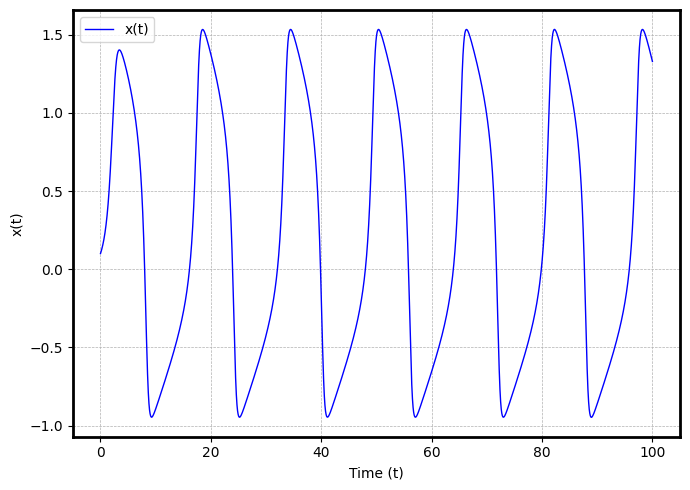

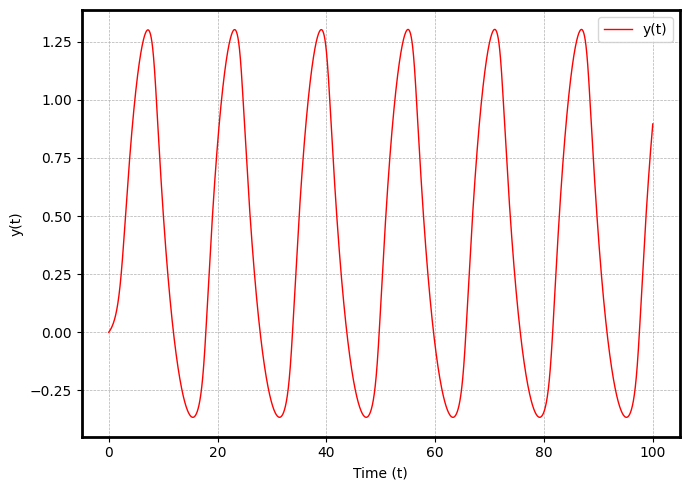

In [24]:
# Plot the original time series obtained corresponding to each variable
# First variable x(t)
fig1, ax1 = plt.subplots(figsize=(7, 5), dpi=100)
ax1.plot(t_train, X[:, 0], color='b', lw=1.0, label='x(t)')
ax1.set(xlabel='Time (t)', ylabel='x(t)')
ax1.legend(loc='best')
ax1.grid(True, which='both', ls='--', lw=0.5)
set_spines_black(ax1)
fig1.tight_layout()
plt.show()


# Second variable y(t)
fig2, ax2 = plt.subplots(figsize=(7, 5), dpi=100)
ax2.plot(t_train, X[:, 1], color='r', lw=1.0, label='y(t)')
ax2.set(xlabel='Time (t)', ylabel='y(t)')
ax2.legend(loc='best')
ax2.grid(True, which='both', ls='--', lw=0.5)
set_spines_black(ax2)
fig2.tight_layout()
plt.show()


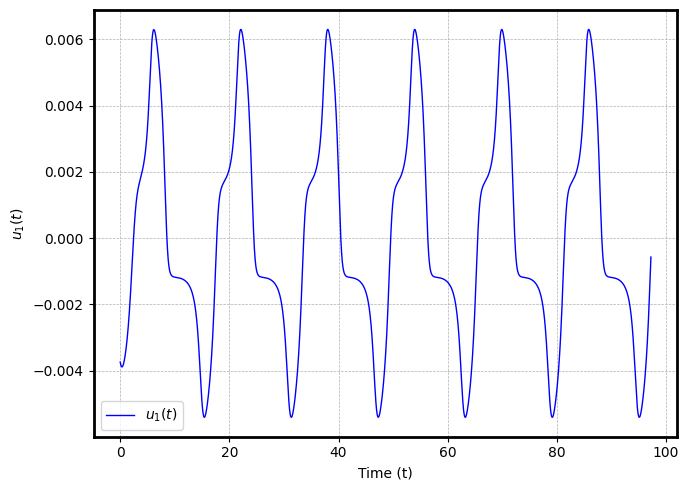

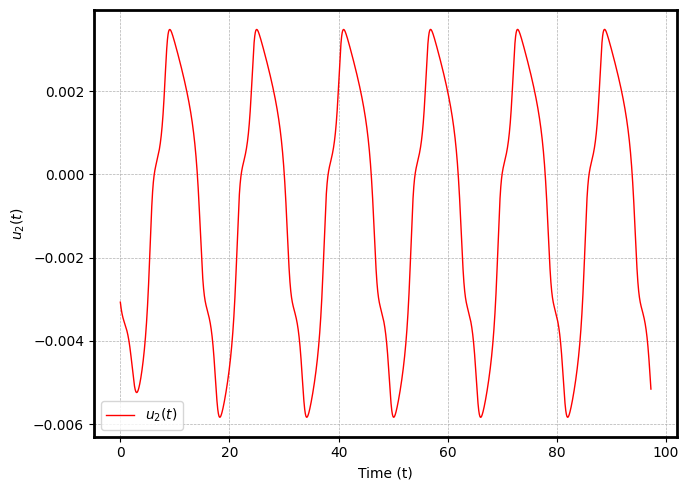

In [25]:
# Plot the time series obtained using SVD
min_len = min(len(t_train), len(U[:, 0]))
# First variable x(t)
fig2, ax2 = plt.subplots(figsize=(7, 5), dpi=100)
ax2.plot(t_train[:min_len], U[:, 1], color='b', lw=1.0, label='$u_1(t)$')
ax2.set(xlabel='Time (t)', ylabel='$u_1(t)$')
ax2.legend(loc='best')
ax2.grid(True, which='both', ls='--', lw=0.5)
set_spines_black(ax2)
fig2.tight_layout()
plt.savefig("Plots_1/Latent_u1_FitzHugh_Nagumo_model.pdf", bbox_inches="tight")
plt.show()

# Second variable y(t)
fig1, ax1 = plt.subplots(figsize=(7, 5), dpi=100)
ax1.plot(t_train[:min_len], U[:, 0], color='r', lw=1.0, label='$u_2(t)$')
ax1.set(xlabel='Time (t)', ylabel='$u_2(t)$')
ax1.legend(loc='best')
ax1.grid(True, which='both', ls='--', lw=0.5)
set_spines_black(ax1)
fig1.tight_layout()
plt.savefig("Plots_1/Latent_u2_FitzHugh_Nagumo_model.pdf", bbox_inches="tight")
plt.show()


In [26]:
#***************************************************************************************************************************************